### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from spn.factory import SpnFactory

from spn.linked.spn import Spn as SpnLinked

from spn.linked.layers import SumLayer as SumLayerLinked
from spn.linked.layers import ProductLayer as ProductLayerLinked
from spn.linked.layers import CategoricalIndicatorLayer
from spn.linked.layers import CategoricalSmoothedLayer

from spn.linked.nodes import SumNode
from spn.linked.nodes import ProductNode
from spn.linked.nodes import CategoricalIndicatorNode
from spn.linked.nodes import CategoricalSmoothedNode
from spn.linked.nodes import CLTreeNode

import time
from spn import MARG_IND
from spn import LOG_ZERO
import matplotlib.pyplot as plt
from pprint import pprint
import numpy
import math
import dataset
import logging
import dataset
import algo.learnspn
from algo.dataslice import DataSlice
import spn.linked.tests.test_spn as test
from pyomo.opt import ProblemFormat

import copy
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pprint import pprint

MAXI = "m"

# <font color='purple'>constructing a SPN

### - by hand

##### this one

In [7]:
dicts = [{'var': 0, 'freqs': [91, 1]},
         {'var': 1, 'freqs': [1, 19]},
         {'var': 2, 'freqs': [7, 76]},
         {'var': 3, 'freqs': [69, 2]}]

In [8]:
def create_valid_toy_spn():
    # root layer
    whole_scope = frozenset({0, 1, 2, 3})
    root_node = SumNode(var_scope=whole_scope)
    root_layer = SumLayerLinked([root_node])

    # prod layer
    prod_node_1 = ProductNode(var_scope=whole_scope)
    prod_node_2 = ProductNode(var_scope=whole_scope)
    prod_layer_1 = ProductLayerLinked([prod_node_1, prod_node_2])

    root_node.add_child(prod_node_1, 0.54)
    root_node.add_child(prod_node_2, 0.46)

    # sum layer
    scope_1 = frozenset({0, 1})
    scope_2 = frozenset({2})
    scope_3 = frozenset({3})
    scope_4 = frozenset({2, 3})

    sum_node_1 = SumNode(var_scope=scope_1)
    sum_node_2 = SumNode(var_scope=scope_2)
    sum_node_3 = SumNode(var_scope=scope_3)
    sum_node_4 = SumNode(var_scope=scope_4)

    prod_node_1.add_child(sum_node_1)
    prod_node_1.add_child(sum_node_2)
    prod_node_1.add_child(sum_node_3)

    prod_node_2.add_child(sum_node_1)
    prod_node_2.add_child(sum_node_4)

    sum_layer_1 = SumLayerLinked([sum_node_1, sum_node_2,
                            sum_node_3, sum_node_4])

    # another product layer
    prod_node_3 = ProductNode(var_scope=scope_1)
    prod_node_4 = ProductNode(var_scope=scope_1)

    prod_node_5 = ProductNode(var_scope=scope_4)
    prod_node_6 = ProductNode(var_scope=scope_4)

    sum_node_1.add_child(prod_node_3, 0.8)
    sum_node_1.add_child(prod_node_4, 0.2)

    sum_node_4.add_child(prod_node_5, 0.5)
    sum_node_4.add_child(prod_node_6, 0.5)

    prod_layer_2 = ProductLayerLinked([prod_node_3, prod_node_4,
                                 prod_node_5, prod_node_6])

    # last sum one
    scope_5 = frozenset({0})
    scope_6 = frozenset({1})

    sum_node_5 = SumNode(var_scope=scope_5)
    sum_node_6 = SumNode(var_scope=scope_6)
    sum_node_7 = SumNode(var_scope=scope_5)
    sum_node_8 = SumNode(var_scope=scope_6)

    sum_node_9 = SumNode(var_scope=scope_2)
    sum_node_10 = SumNode(var_scope=scope_3)
    sum_node_11 = SumNode(var_scope=scope_2)
    sum_node_12 = SumNode(var_scope=scope_3)

    prod_node_3.add_child(sum_node_5)
    prod_node_3.add_child(sum_node_6)
    prod_node_4.add_child(sum_node_7)
    prod_node_4.add_child(sum_node_8)

    prod_node_5.add_child(sum_node_9)
    prod_node_5.add_child(sum_node_10)
    prod_node_6.add_child(sum_node_11)
    prod_node_6.add_child(sum_node_12)

    sum_layer_2 = SumLayerLinked([sum_node_5, sum_node_6,
                            sum_node_7, sum_node_8,
                            sum_node_9, sum_node_10,
                            sum_node_11, sum_node_12])

    # input layer
    vars = [2, 2, 2, 2]
    input_layer = CategoricalSmoothedLayer(vars=vars, node_dicts=dicts)
    last_sum_nodes = [sum_node_2, sum_node_3,
                      sum_node_5, sum_node_6,
                      sum_node_7, sum_node_8,
                      sum_node_9, sum_node_10,
                      sum_node_11, sum_node_12]
    for sum_node in last_sum_nodes:
        (var_scope,) = sum_node.var_scope
        for input_node in input_layer.nodes():
            if input_node.var == var_scope:
                sum_node.add_child(input_node, 1.0)

    spn = SpnLinked(input_layer=input_layer,
              layers=[sum_layer_2, prod_layer_2,
                      sum_layer_1, prod_layer_1,
                      root_layer])
    

    # print(spn)
    return spn


In [181]:
SPN = create_valid_toy_spn()

#### or this one

In [3]:
def create_valid_toy_spn2():
    # root layer
    whole_scope = frozenset({0, 1})
    root_node = SumNode(var_scope=whole_scope)
    root_layer = SumLayerLinked([root_node])

    # prod layer
    prod_node_1 = ProductNode(var_scope=whole_scope)
    prod_node_2 = ProductNode(var_scope=whole_scope)
    prod_node_3 = ProductNode(var_scope=whole_scope)
    prod_layer = ProductLayerLinked([prod_node_1, prod_node_2, prod_node_3])

    root_node.add_child(prod_node_1, 0.2)
    root_node.add_child(prod_node_2, 0.5)
    root_node.add_child(prod_node_3, 0.3)

    # input layer
    node1 = CategoricalSmoothedNode(var=1, var_values=[2], freqs=[0,1], alpha =0)
    node2 = CategoricalSmoothedNode(var=0, var_values=[2,2], freqs=[6,4], alpha =0)
    node3 = CategoricalSmoothedNode(var=1, var_values=[2,2], freqs=[8,2], alpha =0)
    node4 = CategoricalSmoothedNode(var=0, var_values=[], freqs=[1,9], alpha =0)
    
    prod_node_1.add_child(node1)
    prod_node_1.add_child(node2)
    prod_node_2.add_child(node2)
    prod_node_2.add_child(node3)
    prod_node_3.add_child(node3)
    prod_node_3.add_child(node4)
    
    input_layer = CategoricalSmoothedLayer([node1,node2,node3,node4])
    
    spn = SpnLinked(input_layer=input_layer,
              layers=[prod_layer,
                      root_layer])

    # print(spn)
    return spn

In [191]:
SPN1 = create_valid_toy_spn2()

In [192]:
SPN1

[sum layer:]
Sum Node id: 43 scope: frozenset({0, 1})
 (44 0.2) (45 0.5) (46 0.3)
**********************************************************

[prod layer:]
Prod Node id: 44 scope: frozenset({0, 1})
 (47) (48)
Prod Node id: 45 scope: frozenset({0, 1})
 (48) (49)
Prod Node id: 46 scope: frozenset({0, 1})
 (49) (50)
**********************************************************

[input layer:]
Categorical Smoothed Node id: 47 scope: frozenset({1})
            var: 1 val: 2 [[0, 1]] [[-1000.0, 0.0]]
Categorical Smoothed Node id: 48 scope: frozenset({0})
            var: 0 val: 2 [[6, 4]] [[-0.51082562376599094, -0.91629073187415533]]
Categorical Smoothed Node id: 49 scope: frozenset({1})
            var: 1 val: 2 [[8, 2]] [[-0.22314355131421015, -1.6094379124341005]]
Categorical Smoothed Node id: 50 scope: frozenset({0})
            var: 0 val: 2 [[1, 9]] [[-2.3025850929940459, -0.10536051565782634]]
**********************************************************

### - by learning on a dataset

In [10]:
## bnetflix with RandomLearn   IDEM cr52, jester

In [145]:
dataset_name1 = 'nltcs'
dataset_name2 = 'jester'
dataset_name3 = "accidents"
dataset_name4 = "dna"

#### with learnSPN

In [146]:
seed =8374849
numpy.random.seed(seed)
rand_gen = numpy.random.RandomState(seed)

def test_learnspn_oneshot(dataset_name):

    logging.basicConfig(level=logging.INFO)
    #
    # loading a very simple dataset
    dataset_name = dataset_name
    train, valid, test = dataset.load_train_val_test_csvs(dataset_name)
    train_feature_vals = [2 for i in range(train.shape[1])]
    print('Loaded dataset', dataset_name)

    #
    # initing the algo
    learnSPN = algo.learnspn.LearnSPN(rand_gen=rand_gen)

    #
    # start learning
    spn = learnSPN.fit_structure(train,
                                 train_feature_vals)
    return spn

In [147]:
#ignoring warnings
import warnings; warnings.simplefilter('ignore')

In [148]:
SPN2 = test_learnspn_oneshot(dataset_name1)
SPN3 = test_learnspn_oneshot(dataset_name2)
SPN4 = test_learnspn_oneshot(dataset_name3)

Loaded dataset nltcs
Loaded dataset jester
Loaded dataset accidents


In [149]:
SPN5 = test_learnspn_oneshot(dataset_name4)

Loaded dataset dna


# <font color='green'> Getting info on the SPN

In [9]:
def print_info(SPN):
    print("is SPN complete and decomposable? : {}".format(SPN.is_complete() and SPN.is_decomposable()))
    print("{} layers in the spn".format(len(SPN._layers)+1))
    print("structured like {} ".format(([SPN._input_layer._n_nodes]+[layer._n_nodes for layer in SPN._layers])[::-1]))
    print("{} variables in his scope".format(len(SPN._root_layer._nodes[0].var_scope)))

In [142]:
print_info(SPN1)

is SPN complete and decomposable? : True
3 layers in the spn
structured like [1, 3, 4] 
2 variables in his scope


In [150]:
print_info(SPN2)

is SPN complete and decomposable? : True
17 layers in the spn
structured like [1, 7, 6, 19, 12, 27, 24, 57, 34, 73, 21, 44, 10, 20, 5, 10, 1027] 
16 variables in his scope


In [37]:
numpy.sum([1, 8, 13, 82, 65, 196, 150, 455, 216, 600, 141, 360, 34, 87, 4, 9, 11927])

14348

In [10]:
print_info(SPN3)

is SPN complete and decomposable? : True
17 layers in the spn
structured like [1, 3, 7, 29, 51, 182, 112, 420, 117, 387, 72, 232, 28, 100, 12, 36, 6281] 
100 variables in his scope


In [11]:
print_info(SPN4)

is SPN complete and decomposable? : True
21 layers in the spn
structured like [1, 3, 14, 59, 143, 586, 592, 2037, 1050, 3107, 970, 2694, 515, 1341, 179, 446, 39, 97, 4, 8, 80083] 
889 variables in his scope


In [12]:
print_info(SPN5)

is SPN complete and decomposable? : True
19 layers in the spn
structured like [1, 12, 28, 129, 157, 525, 233, 750, 244, 726, 181, 476, 47, 111, 10, 21, 1, 2, 14279] 
100 variables in his scope


In [21]:
# remember calculation times
calculation_time = {'poon': [], 'bb_fr': [],'bb_fr_hs': [], 'bb_con': [],'bb_con_hs': [],'solver': []}

# The Poon algorithm

In [93]:
start_time = time.time()
poon_max1, poon_evid1 = SPN1.MPE_poon_eval()
timing = round(time.time() - start_time, 6)
calculation_time['poon'].append(timing)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [159]:
start_time = time.time()
poon_max2, poon_evid2 = SPN2.MPE_poon_eval()
timing = round(time.time() - start_time, 6)
calculation_time['poon'].append(timing)

the maximum found by Poon algo is 0.17678644097995788


In [160]:
timing

0.008323

In [163]:
start_time = time.time()
poon_max3, poon_evid3 = SPN3.MPE_poon_eval()
timing = round(time.time() - start_time, 6)
calculation_time['poon'].append(timing)

the maximum found by Poon algo is 0.0019665610781779658


In [166]:
timing

0.076948

In [165]:
start_time = time.time()
poon_max4, poon_evid4 = SPN4.MPE_poon_eval()
timing = round(time.time() - start_time, 6)
calculation_time['poon'].append(timing)

the maximum found by Poon algo is 3.9380547654164454e-07


In [161]:
start_time = time.time()
poon_max5, poon_evid5 = SPN5.MPE_poon_eval()
timing = round(time.time() - start_time, 6)
calculation_time['poon'].append(timing)

the maximum found by Poon algo is 5.773136045385846e-09


## Branch&Bound

In [13]:
%matplotlib inline

## LAZY version
def branch_and_bound(spn, hot_start=True, heuristic="frequency", verbose=False):
     
    #Find branching order (from the variable most frequent in nodes, to the less)
    
    scope = spn._root_layer._nodes[0].var_scope
    assert(len(scope) == max(scope) + 1)
    var_presence =  [0]*len(scope)
    for node in spn._input_layer._nodes:
        probs = numpy.exp(node._var_probs)
        if heuristic == "frequency":
            var_presence[node.var]+= 1
        elif heuristic == "conflict":
             var_presence[node.var]+= abs(probs[0] - probs[1])
        else:
            print("unimplemented heuristics")
            return 0
    branching_order = [i[0] for i in sorted(enumerate(var_presence), key=lambda x: -x[1])]
    
    #the root node of the B&B
    root_evidence = [MAXI]*len(scope)
    
    #the stack
    stack = [(root_evidence, 0)]
    
    #the initial incumbent
    if hot_start:
        max_so_far, realized_by  = spn.MPE_poon_eval()
    else:
        max_so_far, realized_by  = 0,[]
    
    #statistics on B&B
    nbr_cut_off = 0
    nbr_nodes_cut = 0
    nbr_nodes_visited = 0
    nbr_nodes = 2**(len(scope)+1)-1
    current_bound = []
    current_max = []
    
    #Start counting time
    start_time = time.time()
    #B&B
    while stack:

        try:
            #current node
            evidence, branching_level = stack.pop()
            nbr_nodes_visited +=1
            
            if verbose:
                if nbr_nodes_visited % 15 == 0:
                    print("{}% of nodes passed (cut or visited)".format(100*(nbr_nodes_cut+nbr_nodes_visited)/nbr_nodes))
                    print("current level explored : {}".format(branching_level))
                    print("current max_so_far is {}".format(max_so_far))
                    print("current bound is {}".format(bound))

            #bounding
            bound, is_a_feasible_solution, evidence_in_case_yes = spn.bound_eval(evidence)

            
            if is_a_feasible_solution and bound > max_so_far :
                max_so_far, realized_by = bound, evidence_in_case_yes
                pass
            
            if bound <= max_so_far: #if bound <= max_so_far, we cut the subproblem
                nbr_cut_off +=1
                nbr_nodes_cut += 2**(len(scope)-branching_level+1)-2
                pass

            elif branching_level == len(scope):
                assert is_a_feasible_solution #feasible solution that is less than max_so_far, forgetting her
            else:
                #next branching is going to be on this variable
                var_to_branch = branching_order[branching_level]

                branch0 = copy.deepcopy(evidence)
                branch0[var_to_branch] = 0

                branch1 = evidence
                branch1[var_to_branch] = 1

                stack.append((branch0, branching_level +1))
                stack.append((branch1, branching_level +1))
                
            current_max.append(max_so_far)
            current_bound.append(bound)
            
        except KeyboardInterrupt:
            return max_so_far, realized_by
            sys.exit(0)
    timing = round(time.time() - start_time, 6)
    print("calculation time was {}".format(timing))
    print("--------------------------------------------------------------")
    print("B&B INFO :")   
    print("{} cut off during B&B".format(nbr_cut_off))
    print("{}% of nodes cut".format(round(100*nbr_nodes_cut/nbr_nodes, 4)))
    print("{} :  number of nodes visited".format(nbr_nodes_visited))
    print("{} :  number of nodes cut".format(nbr_nodes_cut))
    print("{} :  total number of nodes".format(nbr_nodes))
    print("--------------------------------------------------------------")
    print("MPE INFO :") 
    print("{} : MPE found".format(max_so_far))
    pprint("realized by evidence: {}".format(realized_by))
    
    return max_so_far, realized_by, (current_bound, current_max), timing

In [14]:
def plot_evolution(curs, names):
    
    plt.figure(1, figsize=(20,10))
    i = 1
    for cur in curs:
        ax = plt.subplot(2,2,i)
        ax.set_title(names[i-1])
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(17)
        
        x = numpy.arange(len(cur[0]))
        plt.plot(x,cur[0], color="r",  linewidth=1)
        plt.plot(x, cur[1], color = "b", linewidth=2)
        i +=1
        
    
    plt.show()

## <font color=purple>SPN1 : simple example

In [59]:
bb_max1, bb_evid1, curs0, t0= branch_and_bound(SPN1, hot_start=False, heuristic="frequency")
print("-----------")
pprint("we enhanced the maximum by a factor {}".format(bb_max1/poon_max1))
calculation_time['bb_fr'].append(t0)

calculation time was 0.000185
--------------------------------------------------------------
B&B INFO :
3 cut off during B&B
28.5714% of nodes cut
5 :  number of nodes visited
2 :  number of nodes cut
7 :  total number of nodes
--------------------------------------------------------------
MPE INFO :
0.3999999999999998 : MPE found
'realized by evidence: [1, 0]'
-----------
'we enhanced the maximum by a factor 1.3333333333333337'


In [60]:
bb_max1, bb_evid1, curs1, t1 = branch_and_bound(SPN1, hot_start=False, heuristic="conflict")
print("-----------")
pprint("we enhanced the maximum by a factor {}".format(bb_max1/poon_max1))
calculation_time['bb_con'].append(t1)

calculation time was 0.000262
--------------------------------------------------------------
B&B INFO :
3 cut off during B&B
28.5714% of nodes cut
5 :  number of nodes visited
2 :  number of nodes cut
7 :  total number of nodes
--------------------------------------------------------------
MPE INFO :
0.3999999999999998 : MPE found
'realized by evidence: [1, 0]'
-----------
'we enhanced the maximum by a factor 1.3333333333333337'


In [61]:
bb_max1, bb_evid1, curs2, t2 = branch_and_bound(SPN1, hot_start=True, heuristic="frequency")
print("-----------")
pprint("we enhanced the maximum by a factor {}".format(bb_max1/poon_max1))
calculation_time['bb_fr_hs'].append(t2)

the maximum found by Poon algo is 0.29999999999999977
calculation time was 0.000185
--------------------------------------------------------------
B&B INFO :
3 cut off during B&B
28.5714% of nodes cut
5 :  number of nodes visited
2 :  number of nodes cut
7 :  total number of nodes
--------------------------------------------------------------
MPE INFO :
0.3999999999999998 : MPE found
'realized by evidence: [1, 0]'
-----------
'we enhanced the maximum by a factor 1.3333333333333337'


In [134]:
bb_max1, bb_evid1, curs3, t3 = branch_and_bound(SPN1, hot_start=True, heuristic="conflict")
print("-----------")
pprint("we enhanced the maximum by a factor {}".format(bb_max1/poon_max1))
calculation_time['bb_con_hs'].append(t3)

NameError: name 'SPN1' is not defined

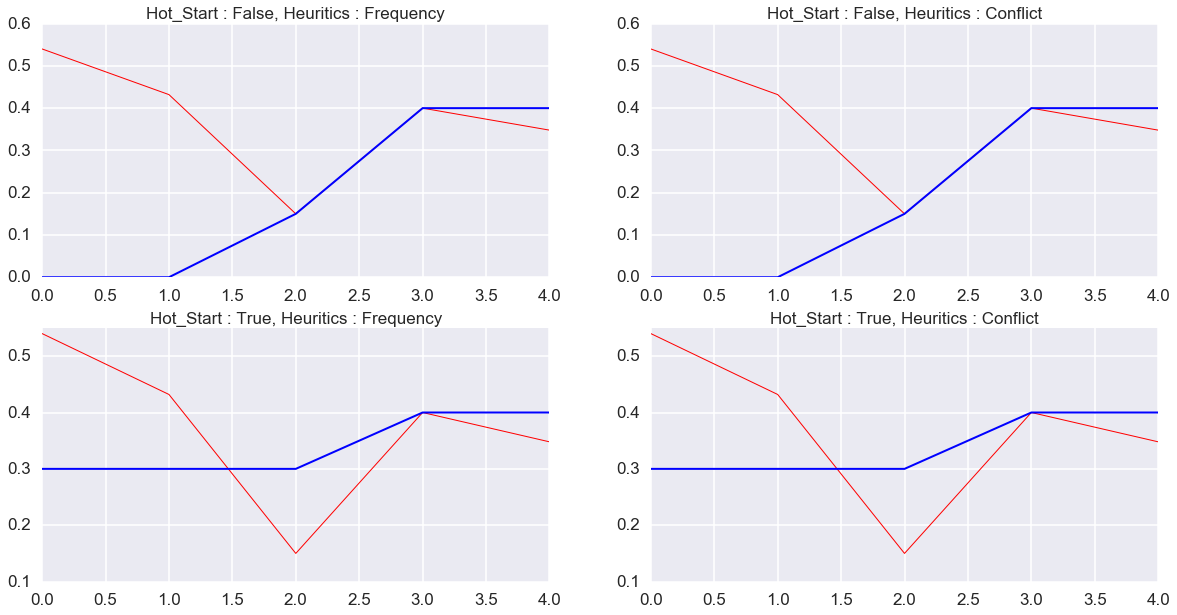

In [63]:
plot_evolution([curs0, curs1, curs2, curs3], names=["Hot_Start : False, Heuritics : Frequency",
                                                    "Hot_Start : False, Heuritics : Conflict",
                                                    "Hot_Start : True, Heuritics : Frequency",
                                                    "Hot_Start : True, Heuritics : Conflict"])

## <font color=purple>SPN2 : a reasonably small data

In [27]:
bb_max2, bb_evid2, curs0, t0 = branch_and_bound(SPN2, hot_start=False, heuristic="frequency")
print("we enhanced the maximum by a factor {}".format(bb_max2/poon_max2))
calculation_time['bb_fr'].append(t0)

NameError: name 'SPN2' is not defined

In [28]:
bb_max2, bb_evid2, curs1, t1 = branch_and_bound(SPN2, hot_start=False, heuristic="conflict")
print("we enhanced the maximum by a factor {}".format(bb_max2/poon_max2))
calculation_time['bb_con'].append(t1)

NameError: name 'SPN2' is not defined

In [55]:
bb_max2, bb_evid2, curs2, t2 = branch_and_bound(SPN2, hot_start=True, heuristic="frequency")
calculation_time['bb_fr_hs'].append(t2)

the maximum found by Poon algo is 9.014706396591743e-24
calculation time was 6.894837
--------------------------------------------------------------
B&B INFO :
253 cut off during B&B
100.0% of nodes cut
505 :  number of nodes visited
3064991081731777716716694054300618367237478244367203846 :  number of nodes cut
3064991081731777716716694054300618367237478244367204351 :  total number of nodes
--------------------------------------------------------------
MPE INFO :
9.220417851976733e-24 : MPE found
('realized by evidence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0,

In [151]:
bb_max2, bb_evid2, curs3, t3 = branch_and_bound(SPN2, hot_start=True, heuristic="conflict")
calculation_time['bb_con_hs'].append(t3)

the maximum found by Poon algo is 0.17678644097995788
calculation time was 0.176639
--------------------------------------------------------------
B&B INFO :
18 cut off during B&B
99.9733% of nodes cut
35 :  number of nodes visited
131036 :  number of nodes cut
131071 :  total number of nodes
--------------------------------------------------------------
MPE INFO :
0.17678644097995788 : MPE found
'realized by evidence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'


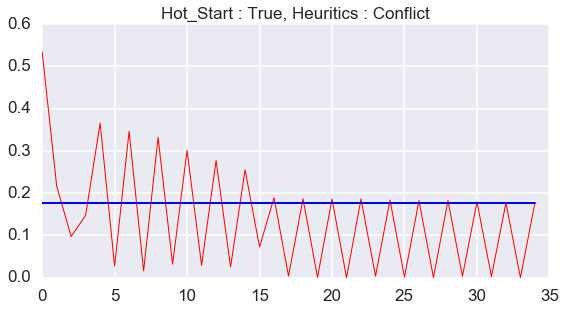

In [152]:
plot_evolution([curs3], names=[#"Hot_Start : False, Heuritics : Frequency",
                                                    #"Hot_Start : False, Heuritics : Conflict",
                                                    #"Hot_Start : True, Heuritics : Frequency",
                                                    "Hot_Start : True, Heuritics : Conflict"])

## <font color=purple>SPN3 : a bit bigger data set (can't run in short times without out start)

In [43]:
#hot start is here necessary
calculation_time['bb_fr'].append(1000)
calculation_time['bb_con'].append(1000)

In [44]:
bb_max3, bb_evid3, curs00, t0 = branch_and_bound(SPN3, hot_start=True, heuristic="frequency")
#print("we enhanced the maximum by a factor {}".format(bb_max3/poon_max3))
calculation_time
calculation_time['bb_fr_hs'].append(t0)

the maximum found by Poon algo is 3.3845878237911285e-19
calculation time was 241.274038
--------------------------------------------------------------
B&B INFO :
5669 cut off during B&B
100.0% of nodes cut
11337 :  number of nodes visited
2535301200456458802993406399414 :  number of nodes cut
2535301200456458802993406410751 :  total number of nodes
--------------------------------------------------------------
MPE INFO :
3.39026159660422e-19 : MPE found
('realized by evidence: [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, '
 '1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, '
 '0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, '
 '1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, '
 '1, 1, 0, 1, 1, 0, 1]')


In [153]:
bb_max3, bb_evid3, curs10, t1 = branch_and_bound(SPN3, hot_start=True, heuristic="conflict")
#print("we enhanced the maximum by a factor {}".format(bb_max3/poon_max3))
calculation_time['bb_con_hs'].append(t1)

the maximum found by Poon algo is 0.0019665610781779658
calculation time was 7.626734
--------------------------------------------------------------
B&B INFO :
101 cut off during B&B
100.0% of nodes cut
201 :  number of nodes visited
2535301200456458802993406410550 :  number of nodes cut
2535301200456458802993406410751 :  total number of nodes
--------------------------------------------------------------
MPE INFO :
0.0019665610781779658 : MPE found
('realized by evidence: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1]')


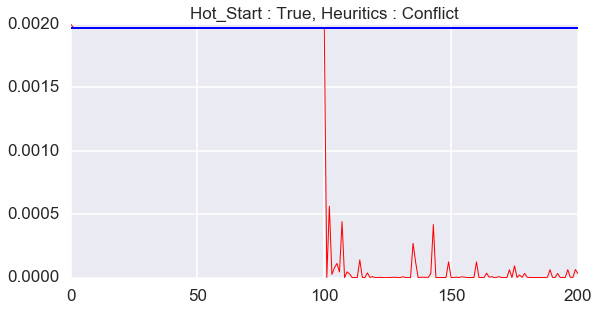

In [154]:
plot_evolution([curs10], names=[#"Hot_Start : False, Heuritics : Frequency",
                                #"Hot_Start : False, Heuritics : Conflict",
                                #"Hot_Start : True, Heuritics : Frequency",
                                  "Hot_Start : True, Heuritics : Conflict"])

## <font color=purple>SPN4 : a big network

In [47]:
#hot start is here necessary
calculation_time['bb_fr'].append(1000)
calculation_time['bb_con'].append(1000)

In [48]:
bb_max4, bb_evid4, curs0, t0 = branch_and_bound(SPN4, hot_start=True, heuristic="frequency")
#print("we enhanced the maximum by a factor {}".format(bb_max4/poon_max4))
calculation_time['bb_fr_hs'].append(t0)

the maximum found by Poon algo is 5.611345981484804e-16


ValueError: not enough values to unpack (expected 4, got 2)

In [155]:
bb_max4, bb_evid4, curs1, t1 = branch_and_bound(SPN4, hot_start=True, heuristic="conflict")
#print("we enhanced the maximum by a factor {}".format(bb_max4/poon_max4))
calculation_time['bb_con_hs'].append(t1)

the maximum found by Poon algo is 3.9380547654164454e-07
calculation time was 20.036538
--------------------------------------------------------------
B&B INFO :
222 cut off during B&B
100.0% of nodes cut
443 :  number of nodes visited
5192296858534827628530496329219652 :  number of nodes cut
5192296858534827628530496329220095 :  total number of nodes
--------------------------------------------------------------
MPE INFO :
3.9380547654164454e-07 : MPE found
('realized by evidence: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]')


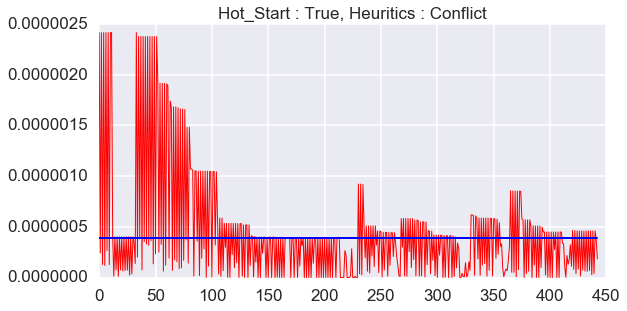

In [156]:
plot_evolution([ curs1], names=[ #"Hot_Start : True, Heuritics : Frequency",
                                        "Hot_Start : True, Heuritics : Conflict"])

## <font color=purple>SPN5 : an even bigger one

In [ ]:
#hot start is here necessary
calculation_time['bb_fr'].append(1000)
calculation_time['bb_con'].append(1000)

In [ ]:
bb_max5, bb_evid5, curs0, t0 = branch_and_bound(SPN5, hot_start=True, heuristic="frequency")
print("we enhanced the maximum by a factor {}".format(bb_max5/poon_max5))
calculation_time['bb_fr_hs'].append(t0)

In [157]:
bb_max5, bb_evid5, curs111, t1 = branch_and_bound(SPN5, hot_start=True, heuristic="conflict")
calculation_time['bb_con_hs'].append(t1)

the maximum found by Poon algo is 5.773136045385846e-09
calculation time was 1.000687
--------------------------------------------------------------
B&B INFO :
28 cut off during B&B
100.0% of nodes cut
55 :  number of nodes visited
3064991081731777716716694054300618367237478244367204296 :  number of nodes cut
3064991081731777716716694054300618367237478244367204351 :  total number of nodes
--------------------------------------------------------------
MPE INFO :
5.773136045385846e-09 : MPE found
('realized by evidence: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, '
 '1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, '
 '0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, '
 '0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, '
 '0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, '
 '0, 1, 0, 0, 0, 0, 0, 0

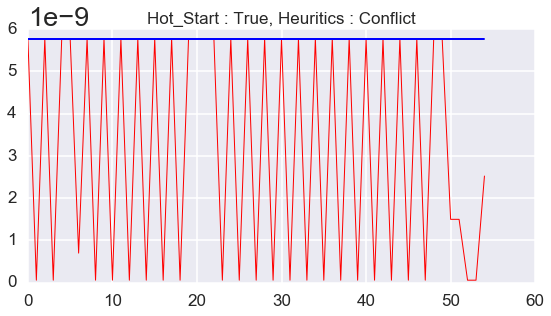

In [158]:
plot_evolution([ curs111], names=[ #"Hot_Start : True, Heuritics : Frequency",
                                        "Hot_Start : True, Heuritics : Conflict"])

## External Solver

### Inititialization

In [80]:
def get_val_dic_for_leaves(evidence):
    return {v: k for v, k in enumerate(evidence)}

In [81]:
dic_leaves1 = get_val_dic_for_leaves(poon_evid1)
dic_leaves2 = get_val_dic_for_leaves(poon_evid2)
dic_leaves3 = get_val_dic_for_leaves(poon_evid3)
dic_leaves4 = get_val_dic_for_leaves(poon_evid4)
dic_leaves5 = get_val_dic_for_leaves(poon_evid5)

### Implementation

In [1]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

def solve(SPN, init=None, write_name=None, solver ="couenne"): # INIT = "bb","poon" or None
    #Scroll through the graph
    var_node, var_indic, constraints = SPN.get_variables_and_constraints1()
    root_eq = SPN.get_big_equation()

    #Set the model
    model = ConcreteModel()

    # Variablest
    if init:
        model.l = Var(var_indic, domain=Boolean, initialize=init)
    else:
        model.l = Var(var_indic, domain=Boolean)

    # Defining the objective
    model.obj = Objective(expr= eval(root_eq), sense=maximize)
    
    if write_name:
        model.write("solving_files/{}.nl".format(write_name), format=ProblemFormat.nl)

    #Solving
    opt = SolverFactory(solver)
    results = opt.solve(model)

    #model.pprint()
    print("--------")
    print("Termination is {}".format(results.Solver.Termination_condition))
    print("Calulation time is {}".format(results.Solver.Time))
    print("MPE found is {}".format(value(model.obj)))
    
    return model, results.Solver.Time

In [83]:
model1, time = solve(SPN1, init=dic_leaves1)
calculation_time['solver'].append(time)

scrolling through the graph
there are 2 layers to visit
end of scrolling through the graph
--------
Termination is optimal
Calulation time is 0.09786701202392578
MPE found is 0.3999999999999998


In [84]:
model2, time = solve(SPN2, init=dic_leaves2)
calculation_time['solver'].append(time)

scrolling through the graph
there are 14 layers to visit
end of scrolling through the graph
--------
Termination is optimal
Calulation time is 51.736510038375854
MPE found is 0.002576775485647275


In [85]:
model3, time = solve(SPN3, init=dic_leaves3)
calculation_time['solver'].append(time)

scrolling through the graph
there are 16 layers to visit
end of scrolling through the graph
  Signal handler called from  //anaconda/lib/python3.5/subprocess.py _try_wait 1608
  Waiting...
  Signaled process 1216 with signal 2
ERROR: "[base]/site-packages/pyomo/opt/base/solvers.py", 599, solve
	Solver (asl) returned non-zero return code (-1)
ERROR: "[base]/site-packages/pyomo/opt/base/solvers.py", 604, solve
	Solver log:
	Couenne 0.5 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
	Mailing list: couenne@list.coin-or.org
	Instructions: http://www.coin-or.org/Couenne
	
	Couenne: new cutoff value -4.9902416518e-08 (0.842427 seconds)
	Reformulation: 0.6 seconds
	NLP0012I 
	              Num      Status      Obj             It       time                 Location
	NLP0014I             1         OPT -1.9749455e-28        5 1.206934
	NLP0014I             2         OPT -2.1003359e-33        0 0
	Loaded instance "/var/folders/ms/8l6d2f516k371pq_w_3qj0mh0000gn/T/tmpk89dv2q5.pyom

ApplicationError: Solver (asl) did not exit normally

In [ ]:
#model4, time = solve(SPN4, init=dic_leaves4, solver = "couenne")

In [ ]:
calculation_time['solver'].append(1000)

In [97]:
model5, time = solve(SPN5, init=dic_leaves5, solver = "couenne")
calculation_time['solver'].append(time)

scrolling through the graph
there are 16 layers to visit
end of scrolling through the graph
WARNING - Loading a SolverResults object with a warning status into model=unknown; message from solver=couenne\x3a Optimization interrupted on limit.
--------
Termination is maxIterations
Calulation time is 311.62675499916077
MPE found is 1.6254183094956745e-15


## Plotting calculation time

In [91]:
calculation_time['solver']+=[1000,1000,1000]

In [92]:
calculation_time

{'bb_con': [0.000262, 3.445567, 1000, 1000, 1000],
 'bb_con_hs': [0.00019, 0.160413, 10.498585, 10.348458, 327.97943],
 'bb_fr': [0.000185, 2.905955, 1000, 1000, 1000],
 'bb_fr_hs': [0.000185, 0.13356, 18.972691, 19.458295, 395.858014],
 'poon': [0.000384, 0.008368, 0.065818, 0.397861, 0.095325],
 'solver': [0.09786701202392578, 51.736510038375854, 1000, 1000, 1000]}

In [93]:
def plot_calculation_time(calculation_time, ylim):
    
    #        ax.set_title(method[1])


    multiple_bars = plt.figure(1, figsize=(20,10))

    x = numpy.arange(1,6)
    
    #data
    p = calculation_time['poon']
    b1 = calculation_time['bb_fr']
    b2 = calculation_time['bb_con']
    b3 = calculation_time['bb_fr_hs']
    b4 = calculation_time['bb_con_hs']
    s = calculation_time['solver']
    
    #font
    ax = plt.subplot(111)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(17)
    
    #bars
    ax.bar(x-0.2, p,width=0.1,color='w',align='center')
    ax.bar(x-0.1, b1,width=0.1,color='b',align='center')
    ax.bar(x, b2,width=0.1,color='g',align='center')
    ax.bar(x+0.1, b3,width=0.1,color='y',align='center')
    ax.bar(x+0.2, b4,width=0.1,color='r',align='center')
    ax.bar(x+0.3, s,width=0.1,color='k',align='center')
    
    #legend
    patches= []
    patches.append(mpatches.Patch(color='w', label='Poon Algorithm'))
    patches.append(mpatches.Patch(color='b', label='B&B frequency'))
    patches.append(mpatches.Patch(color='g', label='B&B conflict'))
    patches.append(mpatches.Patch(color='y', label='B&B frequency hot-start'))
    patches.append(mpatches.Patch(color='r', label='B&B conflict hot-start'))
    patches.append(mpatches.Patch(color='k', label='External solver'))
    plt.legend(handles=patches, loc = 2)
    
    ax.set_ylim([0,ylim])
    
    plt.show()

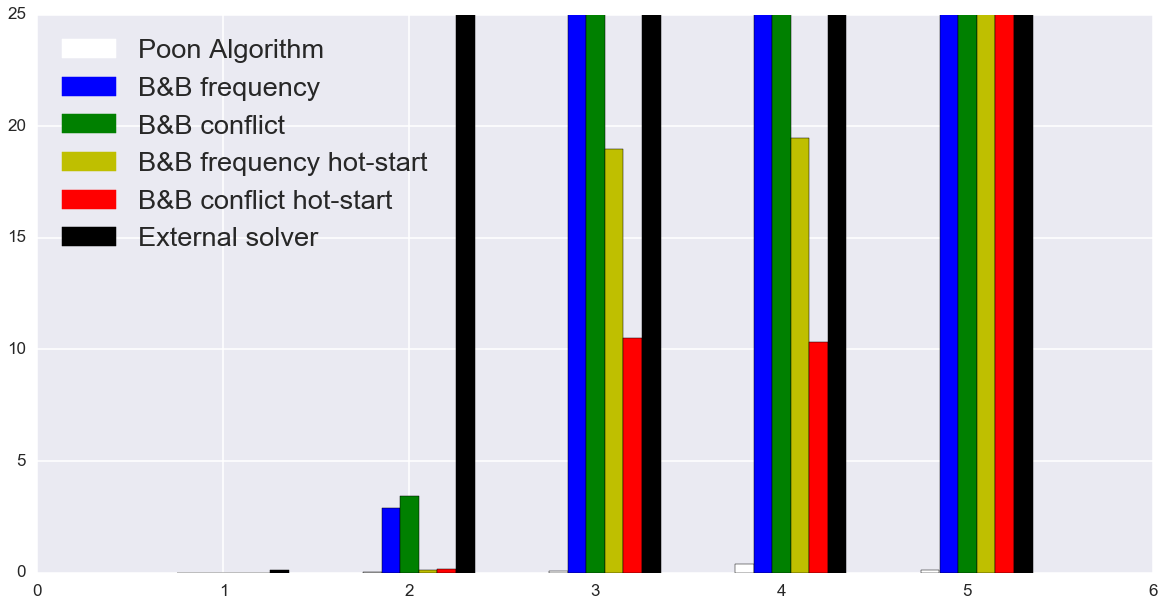

In [94]:
plot_calculation_time(calculation_time, 25)

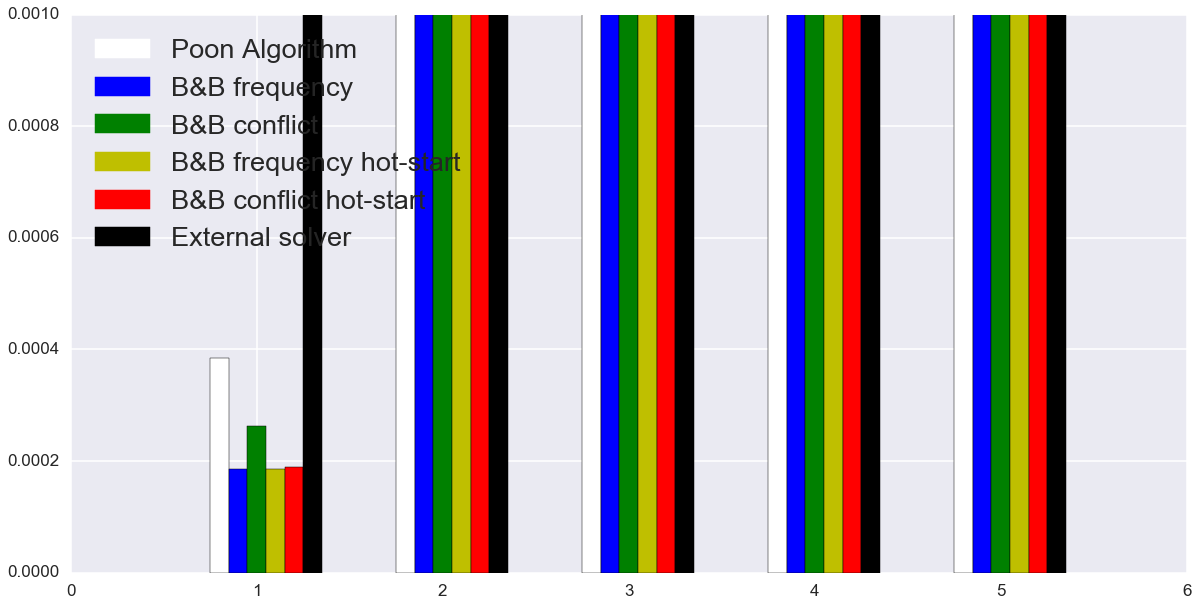

In [96]:
plot_calculation_time(calculation_time, 0.001)

In [99]:
exp(-1.204)+exp(-0.357)

0.9997643391433315

## testing all possibilities

In [ ]:
evs=[]
pourcent = 0.1
for i in range(2**16):

    if i>=2**16*pourcent:
        print("{}% done".format(int(100*pourcent)))
        pourcent+=0.1

    binary = list(str(bin(i))[2:])
    a = len(binary)
    while a < 16:
        a+=1
        binary.append('0')
    ev = numpy.array([int(j) for j in binary])

        
    evs.append(numpy.exp(SPN.exact_eval(ev))[0])

In [ ]:
numpy.argmax(evs)

In [ ]:
numpy.exp(SPN._input_layer._nodes[0]._var_probs)

In [ ]:
scope = SPN._root_layer._nodes[0].var_scope
assert(len(scope) == max(scope) + 1)
var_sum_conflict =  [0]*len(scope)
for node in SPN._input_layer._nodes:
    probs = numpy.exp(node._var_probs)
    var_presence[node.var]+= 1 #abs(probs[0] - probs[1])**4
branching_order2 = [i[0] for i in sorted(enumerate(var_presence), key=lambda x: -x[1])]

In [ ]:
var_presence.sort()

In [ ]:
pprint(branching_order)

In [ ]:
pprint(branching_order2)

## <font color=purple> Transorm AC in SPN

In [5]:
with open('../ocaml/nltcs.spn/spac.m') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip().split(" ") for x in content]

In [112]:
for i in range (1,15):
    with open('../ocaml/{}.spn/spac-{}.ac'.format("nltcs", i)) as f:
        content = f.readlines()
    content = [x.strip().split(" ") for x in content]
    nbr_var = len(content[0])
    eof = content.index(["EOF"])

    content = content[1:eof] ##stopping at first EOF and removing var description (0)
    
    n=len(content)-1
    print(i, find_scope_c(content, n))

1 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
2 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
3 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
4 {0}
5 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
6 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
7 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
8 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
9 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
10 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
11 {0, 1, 2, 3, 4, 5}
12 {0, 1, 2, 3, 4, 5, 6, 7, 8}
13 {0, 1, 2, 3, 4, 5}
14 {0, 1, 2, 3, 4, 5}


In [84]:
def find_scope_c(content, i):
    line = content[i]
    if line[0]=='v':
        return set([int(line[1])])
    elif line[0]=='+':
        s = find_scope_c(content, int(line[1]))
        for child in line[2:]:
            b= find_scope_c(content, int(child))
            if b != s:
                print("prob")
        return s
    
    elif line[0]=='*':
        s = find_scope_c(content, int(line[1]))
        for child in line[2:]:
            b= find_scope_c(content, int(child))
            for elem in b:
                if b in s:
                    print('prob x')
                else:
                    s = s | set([elem])
        return s
    
    
    
    elif line[0]=='n':
        return set([])        


In [82]:
def is_c(content):
    for i in range(len(content)):
        line = content[i]
        scope = find_scope_c(content,i)
        if line[0]=="+":
            for child in line[1:]:
                c_s = find_scope_c(content, int(child))
                if c_s !=scope :
                    print("pooobdza")
            

In [3]:
import networkx as nx

def parse_spn(spn_name):
    
    with open('../ocaml/{}.spn/spac.m'.format(spn_name)) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip().split(" ") for x in content]
    
    G = nx.DiGraph()
    nodes = {}
    nbr_node_visited = 0
    i = len(content) - 1
    while i > 1:
        node_info = content[i]
        while node_info[0] != 'n':
            i -=1
            node_info = content[i]
            
        for node_id in G.nodes():
            try:
                a = G.node[node_id]['n_type']
            except:
                print("{} has no ntype : IMPOSSIBLE".format(node_id))
        
        n_id, node_type, p_id = int(node_info[1]), node_info[2], int(node_info[3])
        print("{}..".format(n_id))
        
        if p_id == -1 :
            root_id = n_id
        
        if node_type == "null":
            i = i-1
            pass
        elif node_type == "+":

            children = list(map(int,content[i+1]))
            log_weights = list(map(float,content[i+2]))
            scope = frozenset(map(int,content[i+3]))
            
            G.add_node(n_id, n_type=node_type)
            for child, log_weight in zip(children,log_weights):
                G.add_edge(n_id, child, weight = math.exp(log_weight))
            i = i - 1
            
            #nodes[n_id] = ('+', SumNode(var_scope = scope), child_ids, log_weights)
            
        elif node_type == "*":
            children = list(map(int,content[i+1]))
            scope = frozenset(map(int,content[i+2]))
            
            G.add_node(n_id, n_type=node_type)
            for child in children:
                G.add_edge(n_id, child)
            i = i - 1

        elif node_type == "ac":
            scope = list(map(int,content[i+1]))
            sc = {i : s for i,s in enumerate(scope)}
            i = i -1
            ##apply function on .ac
            parse_ac(G, spn_name, n_id, sc)
            
                
                
    # delete all nodes * and + nodes without children, created by the suppression of parameter nodes:
    n_nodes = G.number_of_nodes() + 1
    while n_nodes != G.number_of_nodes():
        n_nodes = G.number_of_nodes()
        for node_id in G.nodes():
            if G.node[node_id]["n_type"] != "v" and not G.successors(node_id):
                G.remove_node(node_id)
    
            
    return G, root_id

In [4]:
import networkx as nx
import math

def parse_ac(G, spn_name, n_id, sc):
    # add every node in the same format in the nodes dic
    print("treating spac-{}".format(n_id))
    
    with open('../ocaml/{}.spn/spac-{}.ac'.format(spn_name, n_id)) as f:
        content = f.readlines()
    content = [x.strip().split(" ") for x in content]
    nbr_var = len(content[0])
    eof = content.index(["EOF"])
    
    content = content[1:eof] ##stopping at first EOF and removing var description (0)

    root_id = len(content) - 1

    #put everything in the graph G


    for node_id, node in enumerate(content):
        node_type = node[0]
        if node_type == 'n':
            G.add_node("spac{}-{}".format(n_id, node_id), n_type=node_type, value=float(node[1]))
        if node_type == 'v':
            ind_variable = int(node[1])
            global_variable = sc[ind_variable]
            G.add_node("spac{}-{}".format(n_id, node_id),
                       n_type=node_type,
                       variable=global_variable,
                       value=int(node[2]))
        if node_type == '*':
            G.add_node("spac{}-{}".format(n_id, node_id), n_type=node_type)
            for child in node[1:]:
                G.add_edge("spac{}-{}".format(n_id,node_id), "spac{}-{}".format(n_id,int(child)))

        if node_type == '+':
            G.add_node("spac{}-{}".format(n_id, node_id), n_type=node_type)
            for child in node[1:]:
                G.add_edge("spac{}-{}".format(n_id,node_id), "spac{}-{}".format(n_id,int(child)),
                          weight=1)
                
    #for every parameter node, find the good edges and multiply it by the param
    
    for node_id in G.nodes():
        
        try:
            a = G.node[node_id]['n_type']
        except:
            print("{} has no ntype".format(node_id))
        
        
        if G.node[node_id]['n_type'] == "n":
            value =  G.node[node_id]['value']
            edges = edges_to_be_multiplied(G, node_id)
            for edge in edges:
                G[edge[1]][edge[0]]["weight"] *= value

            G.remove_node(node_id) 
    
    
    # if the root is not a sum node, add a sum node
    if G.node["spac{}-{}".format(n_id, root_id)]['n_type'] != "+":
        G.add_node("spac{}-{}".format(n_id, root_id+1), n_type = '+')
        G.add_edge("spac{}-{}".format(n_id, root_id+1), 
                   "spac{}-{}".format(n_id, root_id), 
                   weight=1)
        root_id +=1
    
    root = "spac{}-{}".format(n_id, root_id)
    nx.relabel_nodes(G, {root : n_id}, copy=False)

In [5]:
##find the first sum node on each path to the root 
def edges_to_be_multiplied(G, node_id):
    edges = [(node_id, parent_id) for parent_id in G.predecessors(node_id)]
    final  = []
    
    while edges:
        for edge in edges:
            if G.node[edge[1]]['n_type'] == "+":
                final.append((edge))
                edges.remove(edge)
            else:

                edges.remove(edge)
                p = edge[1]
                edges = edges + [(p,parent_id) for parent_id in G.predecessors(p)]
    return list(set(final))

In [ ]:

    # find layer of each node
    print("finding layers")
    counter= 0
    node_to_layer = {}
    
    for node_id in H.nodes():
        
        queue = [(node,1) for node in H.successors(node_id)]
        
        l=0
        
        while queue:
            n, l = queue.pop(0)
            queue = queue + [(a, l+1) for a in H.successors(n)]

        if (H.node[node_id]["n_type"] == "+" and l % 2 == 0) \
        or (H.node[node_id]["n_type"] == "*" and l % 2 == 1):
            l+=1
        node_to_layer[node_id] = l




""" #define first layer
    print("finding layers")
    counter= 0
    node_to_layer = {}
    queue = []
    for node_id in H.nodes():
        counter +=1
        if H.node[node_id]["n_type"] == "v":
            node_to_layer[node_id] = 0
            queue.append((node_id,0))
    
    # find layer of each node
    while queue:
        node_id, layer_nbr = queue.pop(0)
        counter +=1 
        
        if counter % 300000 == 0 :
            print(len(queue))
        
        for parent in H.predecessors(node_id):
            l = layer_nbr + 1
            if (H.node[parent]["n_type"] == "+" and l % 2 == 0) \
            or (H.node[parent]["n_type"] == "*" and l % 2 == 1):
                l+=1
            node_to_layer[parent] = l
            queue.append((parent, l))"""
            

In [6]:
def nx_to_spyn(H):
    

    #define first layer
    print("finding layers")
    counter= 0
    node_to_layer = {}
    queue = []
    for node_id in H.nodes():
        counter +=1
        if H.node[node_id]["n_type"] == "v":
            node_to_layer[node_id] = 0
            queue.append((node_id,0))
    
    # find layer of each node
    while queue:
        node_id, layer_nbr = queue.pop(0)
        counter +=1 
        
        if counter % 300000 == 0 :
            print(len(queue))
        
        for parent in H.predecessors(node_id):
            l = layer_nbr + 1
            if (H.node[parent]["n_type"] == "+" and l % 2 == 0) \
            or (H.node[parent]["n_type"] == "*" and l % 2 == 1):
                l+=1
            node_to_layer[parent] = l
            queue.append((parent, l))
            
    #create the spyn
    nodes = {}
    nbr_of_layers = node_to_layer[0] + 1
    layers = [[] for _dummy in range(nbr_of_layers)]
    print("creating nodes")
    #create the nodes 
    for node_id in H.nodes():
        node = H.node[node_id]
        if node['n_type']=="+":
            nodes[node_id] = SumNode(var_scope=frozenset(find_scope(node_id, H)))
        elif node['n_type']=="*":
            nodes[node_id] = ProductNode(var_scope=frozenset(find_scope(node_id, H)))
        elif node['n_type']=="v":
            v = node["value"]
            f = [1-v, v]
            nodes[node_id] = CategoricalSmoothedNode(var=node["variable"],
                                                     var_values=[], 
                                                     freqs=f, 
                                                     alpha =0)
        layers[node_to_layer[node_id]].append(nodes[node_id])

    print("creating edges")
    #create the edge
    for edge in H.edges():
        if H.node[edge[0]]["n_type"] == '+':
            nodes[edge[0]].add_child(nodes[edge[1]], H.edge[edge[0]][edge[1]]["weight"])
        if H.node[edge[0]]["n_type"] == '*':
            nodes[edge[0]].add_child(nodes[edge[1]])
    
    print("creating layers")
    
    #create the layers
    layer_spyn = []
    for i, layer in enumerate(layers):
        if not layer :
            print('passing')
            continue
        if i == 0:
            input_layer = CategoricalSmoothedLayer(layers[0])
        else :
            if i % 2 == 1:
                l = SumLayerLinked(layers[i])
                l.normalize()
                layer_spyn.append(l)
            else :
                layer_spyn.append(ProductLayerLinked(layers[i]))
        
    print(len(layer_spyn))
    print("constructing SPN")
    spn = SpnLinked(input_layer=input_layer,
              layers=layer_spyn)
    
    return spn

In [7]:
def find_scope(node_id, G):
    if G.node[node_id]["n_type"] == 'v':
        return set([G.node[node_id]["variable"]])
    else:
        scope = set([])
        for child in G.successors(node_id):
            scope = scope | find_scope(child, G)
        return scope

In [8]:
G2, r1 = parse_spn("nltcsk2")
G3, r1 = parse_spn("nltcsk3")
G4, r1 = parse_spn("nltcsk4")
G5, r1 = parse_spn("nltcsk5")

12..
11..
10..
9..
8..
treating spac-8
7..
treating spac-7
6..
5..
treating spac-5
4..
3..
2..
1..
treating spac-1
0..
19..
18..
17..
16..
15..
treating spac-15
14..
treating spac-14
13..
treating spac-13
12..
treating spac-12
11..
treating spac-11
10..
treating spac-10
9..
treating spac-9
8..
7..
treating spac-7
6..
5..
treating spac-5
4..
3..
treating spac-3
2..
1..
0..
22..
21..
20..
19..
18..
treating spac-18
17..
treating spac-17
16..
treating spac-16
15..
treating spac-15
14..
13..
treating spac-13
12..
treating spac-12
11..
treating spac-11
10..
treating spac-10
9..
treating spac-9
8..
treating spac-8
7..
treating spac-7
6..
5..
treating spac-5
4..
3..
2..
1..
treating spac-1
0..
25..
24..
23..
22..
21..
20..
19..
18..
17..
16..
15..
14..
13..
12..
treating spac-12
11..
treating spac-11
10..
treating spac-10
9..
treating spac-9
8..
treating spac-8
7..
treating spac-7
6..
5..
treating spac-5
4..
treating spac-4
3..
treating spac-3
2..
1..
treating spac-1
0..


In [9]:
spn2 = nx_to_spyn(G2)
spn3 = nx_to_spyn(G3)
spn4 = nx_to_spyn(G4)
spn5 = nx_to_spyn(G5)

finding layers
42474
48348
44915
20135
creating nodes
creating edges
creating layers
passing
passing
passing
46
constructing SPN
finding layers
66344
90243
103737
115809
117531
112991
102219
74209
11885
creating nodes
creating edges
creating layers
passing
passing
passing
46
constructing SPN
finding layers
45135
50725
41908
creating nodes
creating edges
creating layers
passing
passing
41
constructing SPN
finding layers
63437
74251
81112
82269
75455
53971
creating nodes
creating edges
creating layers
passing
passing
41
constructing SPN


In [10]:
print(spn2.is_valid())
print(spn3.is_valid())
print(spn4.is_valid())
print(spn5.is_valid())

True
True
True
True


In [232]:
spn4.MPE_poon_eval() 

the maximum found by Poon algo is 0.17582527487691932


(0.17582527487691932, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
branch_and_bound(spn2)

the maximum found by Poon algo is 0.0064287181459060086
calculation time was 30.587583
--------------------------------------------------------------
B&B INFO :
300 cut off during B&B
99.543% of nodes cut
599 :  number of nodes visited
130472 :  number of nodes cut
131071 :  total number of nodes
--------------------------------------------------------------
MPE INFO :
0.0064287181459060086 : MPE found
'realized by evidence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'


(0.0064287181459060086,
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 ([0.9178321768848117,
   0.22543593423428918,
   0.11881310747416744,
   0.06870112599688476,
   0.05124539693500759,
   0.032020754510656654,
   0.02716488175271835,
   0.020209105725912096,
   0.017479713349359417,
   0.009793258027980018,
   0.009688374998091281,
   0.006333908753982086,
   0.0033547490862683364,
   4.718828967345352e-05,
   0.00763569741686162,
   0.0071766813445249995,
   0.004249326090765269,
   0.0029049414244876554,
   0.0005417792638475186,
   0.0021578573943525905,
   0.006385069306652398,
   0.0031704151287695634,
   0.016981460424150063,
   0.015389639031863342,
   0.010957080478087073,
   0.009406988575434433,
   0.004667305731266797,
   0.0046642656963078255,
   0.0007692946211029017,
   0.0036510451355775257,
   0.0036948438845770732,
   0.019636492816002233,
   0.008842880234666155,
   0.006218616211960261,
   0.0017593206315028517,
   0.01210176334881667,
   0.01021466031559852

## From tree to graph

In [165]:
SPN2._input_layer._nodes[0].var_scope

frozenset({12})

In [151]:
a[frozenset([2,4])]= 4

In [177]:
def cluster_spn(spn, i):
    clustering  = {}
    for layer in [spn._input_layer] + spn._layers:
        all_node_in_layer_higher = True
        for node in layer._nodes:
            len_scope = len(node.var_scope)
            all_node_in_layer_higher = all_node_in_layer_higher and (len_scope > i)
            if len_scope == i:
                if node.var_scope in clustering :
                     clustering[node.var_scope].append(node)
                else:
                    clustering[node.var_scope] = [node]
        if all_node_in_layer_higher :
            return clustering
    return clustering

In [181]:
cluster_spn(SPN2, 2)

{frozenset({5, 7}): [Prod Node id: 4378 scope: frozenset({5, 7})
   (4721) (4722), Prod Node id: 4379 scope: frozenset({5, 7})
   (4723) (4724), Sum Node id: 3896 scope: frozenset({5, 7})
   (4378 0.689922480620155) (4379 0.31007751937984496)],
 frozenset({1, 11}): [Prod Node id: 4726 scope: frozenset({1, 11})
   (4985) (4986), Prod Node id: 4727 scope: frozenset({1, 11})
   (4987) (4988), Sum Node id: 4381 scope: frozenset({1, 11})
   (4726 0.3023255813953488) (4727 0.6976744186046512), Prod Node id: 4432 scope: frozenset({1, 11})
   (4787) (4788), Prod Node id: 4433 scope: frozenset({1, 11})
   (4789) (4790), Sum Node id: 3964 scope: frozenset({1, 11})
   (4432 0.7866666666666666) (4433 0.21333333333333335)],
 frozenset({6, 7}): [Prod Node id: 3803 scope: frozenset({6, 7})
   (4319) (4320), Prod Node id: 3804 scope: frozenset({6, 7})
   (4321) (4322), Sum Node id: 3245 scope: frozenset({6, 7})
   (3803 0.544) (3804 0.456)],
 frozenset({3, 13}): [Prod Node id: 4961 scope: frozenset({3

In [179]:
SPN1

[sum layer:]
Sum Node id: 64915 scope: frozenset({0, 1})
 (64916 0.2) (64917 0.5) (64918 0.3)
**********************************************************

[prod layer:]
Prod Node id: 64916 scope: frozenset({0, 1})
 (64919) (64920)
Prod Node id: 64917 scope: frozenset({0, 1})
 (64920) (64921)
Prod Node id: 64918 scope: frozenset({0, 1})
 (64921) (64922)
**********************************************************

[input layer:]
Categorical Smoothed Node id: 64919 scope: frozenset({1})
            var: 1 val: 2 [[3, 7]] [[-1.2039728043259361, -0.35667494393873267]]
Categorical Smoothed Node id: 64920 scope: frozenset({0})
            var: 0 val: 2 [[6, 4]] [[-0.51082562376599094, -0.91629073187415533]]
Categorical Smoothed Node id: 64921 scope: frozenset({1})
            var: 1 val: 2 [[8, 2]] [[-0.22314355131421015, -1.6094379124341005]]
Categorical Smoothed Node id: 64922 scope: frozenset({0})
            var: 0 val: 2 [[1, 9]] [[-2.3025850929940459, -0.10536051565782634]]
**************